# Customer Behavior Prediction using Deep Learning

Author: Tatsiana Mihai

## Project description

For this project I'll use public datasets with user behavior information available on Kaggle:
- Model training: E-commerce behavior data from multi category store for November 2019
https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
- Validating model robustness: E-commerce behavior data from multi category store for January 2020 https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store


## Data exploration

In [1]:
# import required packages

import pandas as pd
import numpy as np

In [18]:
# read csv file and get the number of rows

df = pd.read_csv('data/2019-Nov.csv')
df.count()

event_time       67501979
event_type       67501979
product_id       67501979
category_id      67501979
category_code    45603808
brand            58277901
price            67501979
user_id          67501979
user_session     67501969
dtype: int64

In [32]:
# show the first rows in the dataframe
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


Let's check the quality of the data. Firts, I want to make sure there're no rows with null or invalid values that might affect model training. 
Let's check which columns have null values and how many.

In [4]:
# show sum of null values for each column

df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    21898171
brand             9224078
price                   0
user_id                 0
user_session           10
dtype: int64

As we can see, there're quite many missed values for `category_code` and `brand`, and also 10 missed values for the `user_session`. 
Now let's check if there're negative `price` values for as they're invalid and will affect the accuracy of the trained model.

In [5]:
# show sum of negative values for the column `price`

(df.price < 0).sum()

0

As we can see, all prices are greater than `0` which makes the dataset is pretty clean. The only issue I'd like to address is the missed values. Also, I'd like to transform composite values in the `category_column` into multi-dimentional features to later try different combinations for model training.

## Data preprocessing

**Reduce dimensionality**  
The dataset is large, however not all of the columns are signficant for model training. The `user_session` column can be dropped as the `user_id` colimn contains all necessary information without missed values. Therefore, I'll remove `user_id` from the dataset.

In [6]:
# keep only necessary columns
required_cols = [
    'event_time',
    'event_type',
    'category_code',
    'product_id',
    'category_id',
    'brand',
    'price',
    'user_id'
]

df = df[required_cols]
df.head()

,event_time,event_type,category_code,product_id,category_id,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,electronics.smartphone,1003461,2053013555631882655,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,appliances.sewing_machine,5000088,2053013566100866035,janome,293.65,530496790
2,2019-11-01 00:00:01 UTC,view,NaN,17302664,2053013553853497655,creed,28.31,561587266
3,2019-11-01 00:00:01 UTC,view,appliances.kitchen.washer,3601530,2053013563810775923,lg,712.87,518085591
4,2019-11-01 00:00:01 UTC,view,electronics.smartphone,1004775,2053013555631882655,xiaomi,183.27,558856683


**Handling the missing values**

As we can see from the data exploration, there're 9224078 missed values in the `brand` column. As there's still other information such as `event_type`, `user_id` and `price`, which can be useful for ML training, I'll fill it with the value `unknown`. 
Apart fron that, some of `category_code` values contain `NaN` instead of expected string values which causes issues with data transformation. I'll fill them with `unknown` values as well.

In [7]:
df['brand'] = df['brand'].fillna('unknown')
df['category_code'] = df['category_code'].fillna('unknown')
df.head()

,event_time,event_type,category_code,product_id,category_id,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,electronics.smartphone,1003461,2053013555631882655,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,appliances.sewing_machine,5000088,2053013566100866035,janome,293.65,530496790
2,2019-11-01 00:00:01 UTC,view,unknown,17302664,2053013553853497655,creed,28.31,561587266
3,2019-11-01 00:00:01 UTC,view,appliances.kitchen.washer,3601530,2053013563810775923,lg,712.87,518085591
4,2019-11-01 00:00:01 UTC,view,electronics.smartphone,1004775,2053013555631882655,xiaomi,183.27,558856683


Let's see how many categories we can restore by mapping their known brands. To do that, I'll get a list of unique combinations of unknown category codes and known brands. 

In [8]:
# extract uniquecvalues from `category_code` and `brand` columns

unknown_cats = df[(df.category_code == 'unknown') & (df.brand != 'unknown')]
unknown_cats = pd.unique(unknown_cats['brand'])

len(unknown_cats)

3036

Now let's explore if it's possible to re-use category that defined for another product with the same `brand` value. To do that I'll fetch all categories from `category_code` for the brands listed in the `unknown_cats`

<Axes: xlabel='category_code'>

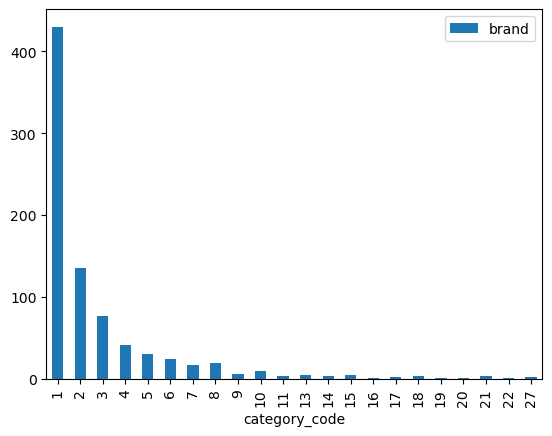

In [9]:
# try to find categories for the brands

known_brands = df[(df.category_code != 'unknown') & (df.brand.isin(unknown_cats))]
known_brands = known_brands[['category_code', 'brand']]
brands_possible_cats = known_brands.groupby(by=['brand']).nunique().reset_index()

# group brands to see how many potential categories each brand has
grouped_known_brands = brands_possible_cats.groupby(by=['category_code']).count()
grouped_known_brands.plot(kind='bar')

As the plot shows, a big chunk of brands has just one possible category. Let's explore some of them

In [10]:
brands_with_single_cat = brands_possible_cats[\
        brands_possible_cats.category_code == 1].brand

known_brands[known_brands.brand.isin(brands_with_single_cat)][210:220]

,category_code,brand
14038,apparel.underwear,milavitsa
14061,apparel.underwear,milavitsa
14092,electronics.audio.subwoofer,element
14105,appliances.environment.vacuum,dyson
14130,apparel.underwear,milavitsa
14139,appliances.sewing_machine,brother
14143,appliances.sewing_machine,janome
14147,appliances.environment.water_heater,ariston
14168,electronics.audio.subwoofer,element
14256,apparel.underwear,milavitsa


In [11]:
brands_with_multi_cat = brands_possible_cats[\
        brands_possible_cats.category_code > 25].brand

known_brands[known_brands.brand.isin(brands_with_multi_cat)].head()

,category_code,brand
0,electronics.smartphone,xiaomi
4,electronics.smartphone,xiaomi
44,appliances.kitchen.dishwasher,bosch
49,electronics.smartphone,xiaomi
69,electronics.smartphone,xiaomi


In [12]:
known_brands[known_brands.brand == 'xiaomi'].head(20)

,category_code,brand
0,electronics.smartphone,xiaomi
4,electronics.smartphone,xiaomi
49,electronics.smartphone,xiaomi
69,electronics.smartphone,xiaomi
82,electronics.audio.headphone,xiaomi
95,electronics.smartphone,xiaomi
121,electronics.smartphone,xiaomi
131,electronics.smartphone,xiaomi
153,electronics.audio.headphone,xiaomi
165,electronics.smartphone,xiaomi


At this moment it's obviout that only the first level category makes sence to be copied and added to the rows with missed values. If I add second or third category level I might affect the quality of the data.

**Data transformation**  
First, I want to transform values from `category_code` into multi-column data `cat_1`, `cat_2`, etc.
To make it I need to know the length of the longest chain in the `category_code` column.

In [13]:
# calculate the max number of categories

max(df.category_code.transform(lambda x: x.str.split('.').transform(lambda y: len(y))))

4

**Imputation**
The maximum length of nested categories is `4`. Now it's possible to create new columns to store each category separately. As only the first layer of categories is to be filled for unknown categories, the other empty values can be filled with `unknown`.  

In [14]:
# split `category_code` column into new columns
df[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = df.category_code.str.split(".", expand = True)
df.head()

,event_time,event_type,category_code,product_id,category_id,brand,price,user_id,cat_1,cat_2,cat_3,cat_4
0,2019-11-01 00:00:00 UTC,view,electronics.smartphone,1003461,2053013555631882655,xiaomi,489.07,520088904,electronics,smartphone,None,None
1,2019-11-01 00:00:00 UTC,view,appliances.sewing_machine,5000088,2053013566100866035,janome,293.65,530496790,appliances,sewing_machine,None,None
2,2019-11-01 00:00:01 UTC,view,unknown,17302664,2053013553853497655,creed,28.31,561587266,unknown,None,None,None
3,2019-11-01 00:00:01 UTC,view,appliances.kitchen.washer,3601530,2053013563810775923,lg,712.87,518085591,appliances,kitchen,washer,None
4,2019-11-01 00:00:01 UTC,view,electronics.smartphone,1004775,2053013555631882655,xiaomi,183.27,558856683,electronics,smartphone,None,None


As the values from the `category_code` column are transferred to another columns, it can be finally removed.

In [15]:
# keep only necessary columns
required_cols = [
    'event_time',
    'event_type',
    'product_id',
    'category_id',
    'cat_1',
    'cat_2',
    'cat_3',
    'cat_4',
    'brand',
    'price',
    'user_id'
]

df = df[required_cols]
df.head()

,event_time,event_type,product_id,category_id,cat_1,cat_2,cat_3,cat_4,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,None,None,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,None,None,janome,293.65,530496790
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,unknown,None,None,None,creed,28.31,561587266
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen,washer,None,lg,712.87,518085591
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,None,None,xiaomi,183.27,558856683


Let's see how many new null varues have been created after changing the dimension of the data.

In [16]:
# show sum of null values for each column

df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
cat_1                 0
cat_2          21898171
cat_3          48685506
cat_4          67438640
brand                 0
price                 0
user_id               0
dtype: int64

The `cat_1` doesn't have empty values as it's been pre-filled with `unknown`. For the others the % of filling is 99.9% for the `cat_2`, 72.1% for the `cat_3`, and 32.4% for the `cat_4`. Though the last column doesn't look promising I'll keep it for know to be able to use it in future training and see how it affects the model.
Let's fill the `unknown` values in `cat_1` with the values from known brands. To make it easier I change `known_brands` in the same way I changed the dataset.

In [17]:
# split `category_code` column into new columns
known_brands[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = known_brands.category_code.str.split(".", expand = True)
known_brands.head()

,category_code,brand,cat_1,cat_2,cat_3,cat_4
0,electronics.smartphone,xiaomi,electronics,smartphone,None,None
1,appliances.sewing_machine,janome,appliances,sewing_machine,None,None
3,appliances.kitchen.washer,lg,appliances,kitchen,washer,None
4,electronics.smartphone,xiaomi,electronics,smartphone,None,None
5,computers.notebook,hp,computers,notebook,None,None


In [18]:
# merge 2 df
known_brands = known_brands[['brand', 'cat_1']].drop_duplicates(subset=['brand'])
known_brands.head()

,brand,cat_1
0,xiaomi,electronics
1,janome,appliances
3,lg,appliances
5,hp,computers
9,apple,electronics


In [19]:
res = pd.merge(df, known_brands, on='brand', how='left')
res.head()

,event_time,event_type,product_id,category_id,cat_1_x,cat_2,cat_3,cat_4,brand,price,user_id,cat_1_y
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,None,None,xiaomi,489.07,520088904,electronics
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,None,None,janome,293.65,530496790,appliances
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,unknown,None,None,None,creed,28.31,561587266,NaN
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen,washer,None,lg,712.87,518085591,appliances
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,None,None,xiaomi,183.27,558856683,electronics


In [20]:
res['cat'] = np.where(res['cat_1_x'] == 'unknown', res.cat_1_y, res.cat_1_x)
res.head()

,event_time,event_type,product_id,category_id,cat_1_x,cat_2,cat_3,cat_4,brand,price,user_id,cat_1_y,cat
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,None,None,xiaomi,489.07,520088904,electronics,electronics
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,None,None,janome,293.65,530496790,appliances,appliances
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,unknown,None,None,None,creed,28.31,561587266,NaN,NaN
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen,washer,None,lg,712.87,518085591,appliances,appliances
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,None,None,xiaomi,183.27,558856683,electronics,electronics


In [21]:
# keep only necessary columns
required_cols = [
    'event_time',
    'event_type',
    'product_id',
    'category_id',
    'cat',
    'cat_2',
    'cat_3',
    'cat_4',
    'brand',
    'price',
    'user_id'
]

res = res[required_cols]
res.head()

,event_time,event_type,product_id,category_id,cat,cat_2,cat_3,cat_4,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,None,None,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,None,None,janome,293.65,530496790
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,None,None,None,creed,28.31,561587266
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen,washer,None,lg,712.87,518085591
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,None,None,xiaomi,183.27,558856683


In [22]:
res.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
cat            13856184
cat_2          21898171
cat_3          48685506
cat_4          67438640
brand                 0
price                 0
user_id               0
dtype: int64

In [23]:
res['cat'] = res['cat'].fillna('unknown')
res['cat_2'] = res['cat_2'].fillna('unknown')
res['cat_3'] = res['cat_3'].fillna('unknown')
res['cat_4'] = res['cat_4'].fillna('unknown')
res.head()

,event_time,event_type,product_id,category_id,cat,cat_2,cat_3,cat_4,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,unknown,unknown,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,unknown,unknown,janome,293.65,530496790
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,unknown,unknown,unknown,unknown,creed,28.31,561587266
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen,washer,unknown,lg,712.87,518085591
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,unknown,unknown,xiaomi,183.27,558856683


#### ML specific preprocessing

Data that is used for training model must be numeric. However, the dataset contains a few columns `string` or `datetime` types. First, let's convert `datetime` in the `event_time` into a `timetuple`

In [24]:
# import required packages
import time
import datetime

res.event_time = res.event_time.apply(lambda x: time.mktime(datetime.datetime.strptime(x,
                                             "%Y-%m-%d %H:%M:%S %Z").timetuple()))

The other columns can be converted to numeric values by using label encoding. I'll use the `LabelEncoder` class that Scikit-learn provides for this purpose.

In [25]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the data
res.event_type = label_encoder.fit_transform(res.event_type)
res.cat = label_encoder.fit_transform(res.cat)
res.cat_2 = label_encoder.fit_transform(res.cat_2)
res.cat_3 = label_encoder.fit_transform(res.cat_3)
res.cat_4 = label_encoder.fit_transform(res.cat_4)
res.brand = label_encoder.fit_transform(res.brand)

res.head()

,event_time,event_type,product_id,category_id,cat,cat_2,cat_3,cat_4,brand,price,user_id
0,1.572566e+09,2,1003461,2053013555631882655,7,41,77,1,4097,489.07,520088904
1,1.572566e+09,2,5000088,2053013566100866035,2,34,77,1,1798,293.65,530496790
2,1.572566e+09,2,17302664,2053013553853497655,13,56,77,1,839,28.31,561587266
3,1.572566e+09,2,3601530,2053013563810775923,2,27,82,1,2152,712.87,518085591
4,1.572566e+09,2,1004775,2053013555631882655,7,41,77,1,4097,183.27,558856683


The dataframe is ready for using in model training. I'll save it to a new .csv file to use it later for training.

In [26]:
# saving in a file
res.to_csv('processed_data.csv')

## Model training

In [2]:
# uncomment lines below if tensorflow isn't installed on your PC

# import sys
# !{sys.executable} -m pip install tensorflow

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

### CNN

In [28]:
# TODO: add


### RNN

In [29]:
# TODO: add


### LSTM

In [30]:
# TODO: add


## Model evaluation

### Baseline comparison

In [3]:
# import packages required for decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# load the preprocessed dataset 
data = pd.read_csv('processed_data.csv')

data.head()

,Unnamed: 0,event_time,event_type,product_id,category_id,cat,cat_2,cat_3,cat_4,brand,price,user_id
0,0,1.572566e+09,2,1003461,2053013555631882655,7,41,77,1,4097,489.07,520088904
1,1,1.572566e+09,2,5000088,2053013566100866035,2,34,77,1,1798,293.65,530496790
2,2,1.572566e+09,2,17302664,2053013553853497655,13,56,77,1,839,28.31,561587266
3,3,1.572566e+09,2,3601530,2053013563810775923,2,27,82,1,2152,712.87,518085591
4,4,1.572566e+09,2,1004775,2053013555631882655,7,41,77,1,4097,183.27,558856683


In [17]:
data[data.event_type == 0][0:5]

,Unnamed: 0,event_time,event_type,product_id,category_id,cat,cat_2,cat_3,cat_4,brand,price,user_id
40,40,1.572566e+09,0,1005014,2053013555631882655,7,41,77,1,3266,503.09,533326659
502,502,1.572567e+09,0,1801881,2053013554415534427,7,57,76,1,3266,488.80,557746614
537,537,1.572567e+09,0,1005115,2053013555631882655,7,41,77,1,196,949.47,565865924
849,849,1.572567e+09,0,1002542,2053013555631882655,7,41,77,1,196,486.80,549256216
956,956,1.572567e+09,0,1004856,2053013555631882655,7,41,77,1,3266,128.42,513645631


In [5]:
# separate features (X) and target (y)
X = data.drop('event_type', axis=1)
y = data['event_type']

# split the data into training and testing sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [6]:
# create a decision tree instance and train it on the training data
des_tree = DecisionTreeClassifier()
des_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [9]:
# make predictions on the test data
y_pred = des_tree.predict(X_test)

# calculate F1 score 
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.90


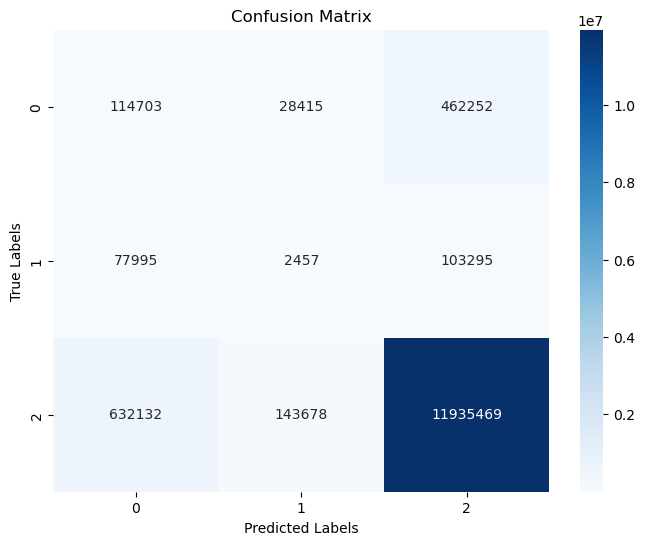

In [10]:
# create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=des_tree.classes_, yticklabels=des_tree.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Model Robustness


In [ ]:
# TODO: import and transform a dataset for verifying the model


## Conclusion